# Image Loading Visualization

In [1]:
from timm.data import Mixup

import torch

def one_hot(x, num_classes, on_value=1., off_value=0.):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=x.device).scatter_(1, x, on_value)

def mixup_target(target, lam=1., smoothing=0.0):
    """
    This function assumes that the input target is already one-hot encoded.
    """
    off_value = smoothing / target.shape[1]
    on_value = 1. - smoothing + off_value
    y1 = target * on_value + (1. - target) * off_value
    y2 = target.flip(0) * on_value + (1. - target.flip(0)) * off_value
    return y1 * lam + y2 * (1. - lam)


class CutMixUp(Mixup):
    def __call__(self, x, target):
        assert len(x) % 2 == 0, 'Batch size should be even when using this'
        if self.mode == 'elem':
            lam = self._mix_elem(x)
        elif self.mode == 'pair':
            lam = self._mix_pair(x)
        else:
            lam = self._mix_batch(x)
        target = mixup_target(target, lam, self.label_smoothing)
            
        return x, target

In [2]:
# Custom dataset class
from typing import Any, Callable, Optional, Dict
from pathlib import Path
from PIL import Image
import random
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from timm.data import Mixup

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader


class MixAugDataset(datasets.ImageFolder):
    def __init__(self, root: str, cmia_path: Path, btia_path: Path,  mixup_args: Dict, cmia_prob=0.0, btia_prob=0.0, aug_num=1, **kwargs):
        super().__init__(root, **kwargs)
        self.cmia_path = cmia_path
        self.cmia_prob = cmia_prob

        self.btia_path = btia_path
        self.btia_prob = btia_prob

        self.aug_num = aug_num

        self.mixup_args = mixup_args
        self.mixup_fn = CutMixUp(**self.mixup_args)

        self.num_classes = len([name for name in os.listdir(root) if os.path.isdir(os.path.join(root, name))])

        default_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])
        self.transforms = kwargs.get('transform', default_transform)
        print("====================Augmentations====================")
        print(f"Using transform: {self.transforms}\n")
        print(f"Using cmia_prob: {self.cmia_prob}\n")
        print(f"Using btia_prob: {self.btia_prob}\n")
        print(f"Using mixup_args: {self.mixup_args}\n")
        print("=====================================================")


    def __getitem__(self, index):
        path, target = self.samples[index]
        return path, target


    def one_hot(self, x, num_classes, on_value=1., off_value=0.):
        x = x.long().view(-1, 1)
        return torch.full((x.size()[0], num_classes), off_value, device=x.device).scatter_(1, x, on_value) 


    def mixup_target(self, target, lam=1., smoothing=0.0):
        off_value = smoothing / self.num_classes
        on_value = 1. - smoothing + off_value
        y1 = self.one_hot(target, self.num_classes, on_value=on_value, off_value=off_value) 
        y2 = self.one_hot(target.flip(0), self.num_classes, on_value=on_value, off_value=off_value) 
        return y1 * lam + y2 * (1. - lam)


    def apply_cmia(self, paths, targets):
        if random.random() < self.cmia_prob:
            print("\nApplying CMIA!")
            for i in range(0, len(paths), 2):  # Iterate over pairs of images
                # Get the class labels and file numbers for the selected images
                class1_name = Path(paths[i]).parent.name
                class2_name = Path(paths[i+1]).parent.name
                file_num1 = Path(paths[i]).stem.split('_')[-1]
                file_num2 = Path(paths[i+1]).stem.split('_')[-1]

                # Construct the CMIA image paths
                cmia_paths1 = glob(str(self.cmia_path / f'{class1_name}_{class2_name}' / f'{file_num1}_*.png'))
                cmia_path1 = cmia_paths1[0] if cmia_paths1 else paths[i]

                cmia_paths2 = glob(str(self.cmia_path / f'{class2_name}_{class1_name}' / f'{file_num2}_*.png'))
                cmia_path2 = cmia_paths2[0] if cmia_paths2 else paths[i+1]

                # Replace the original paths with the CMIA paths
                paths[i] = cmia_path1
                paths[i+1] = cmia_path2

                # Apply mixup only to the labels of the two images that we are augmenting
                targets[i], targets[i+1] = targets[i] * 0.5 + targets[i+1] * 0.5, targets[i+1] * 0.5 + targets[i] * 0.5


        return paths, targets



    def apply_btia(self, paths, targets):
        """Apply BTIA augmentation."""
        if random.random() < self.btia_prob:
            print("\nApplying BTIA!")
            
            new_paths = []
            for path in paths:
                class_name = Path(path).parent.name
                file_num = Path(path).stem.split('_')[-1]
                
                # Find all augmented images corresponding to the original image, limited by k
                corresponding_images = [str(self.btia_path / class_name / f'{file_num}_{i}.png') for i in range(self.aug_num)]
                
                # Filter out non-existing paths
                corresponding_images = [img for img in corresponding_images if Path(img).exists()]

                if corresponding_images:
                    # Randomly choose one from the augmented images
                    new_path = random.choice(corresponding_images)
                else:
                    new_path = path  # if no corresponding image, keep the original
                
                new_paths.append(new_path)
            
            paths = new_paths
            
        return paths, targets


    def apply_mixup_cutmix(self, images, targets):
        """Apply mixup and cutmix augmentation."""
        images, targets = self.mixup_fn(images, targets)
        return images, targets


    def collate_fn(self, batch):
        assert len(batch) % 2 ==0, "batch size should be even when using this code"

        paths, targets = list(zip(*batch))
        paths = list(paths)
        targets = list(targets)
        
        # Convert labels to one-hot format
        targets = self.one_hot(torch.tensor(targets, dtype=torch.int64), self.num_classes)
        
        # Apply augmentations
        paths, targets = self.apply_cmia(paths, targets)
        paths, targets = self.apply_btia(paths, targets)
        print(f"path: {paths}")
        
        images = [default_loader(path) for path in paths]

        # Apply transforms
        images = [self.transforms(image) for image in images]
        images = torch.stack(images)
        # resize_transform = Resize((512, 512))
        # images = [resize_transform(image) for image in images]
        # images = torch.stack([ToTensor()(image) for image in images])

        # Apply mixup and cutmix after loading and resizing the images
        images, targets = self.apply_mixup_cutmix(images, targets)

        return images, targets

In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
                         ])

mixup_args = {
    'mixup_alpha': 1.,
    'cutmix_alpha': 1.,
    'cutmix_minmax': None,
    'prob': 0.,
    'switch_prob': 0.5,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 10}

In [12]:
root = '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000'
cmia_path = Path('/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_cmia')
btia_path = Path('/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT')
dataset = MixAugDataset(root, cmia_path, btia_path, mixup_args=mixup_args, cmia_prob=0.0, btia_prob=0.8, aug_num=5) 
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=dataset.collate_fn)

====================Augmentations====================
Using transform: Compose(
    Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

Using cmia_prob: 0.0

Using btia_prob: 0.8

Using mixup_args: {'mixup_alpha': 1.0, 'cutmix_alpha': 1.0, 'cutmix_minmax': None, 'prob': 0.0, 'switch_prob': 0.5, 'mode': 'batch', 'label_smoothing': 0, 'num_classes': 10}



In [13]:
for images, labels in dataloader:
    images = images
    labels = labels
    print(images.shape)
    print(labels.shape)
    break


Applying BTIA!
path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n03733805/10061_3.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n03764736/10011_4.png']

Applying BTIA!
path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02094433/10057_1.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02391049/10007_1.png']

Applying BTIA!
Applying BTIA!

path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02106662/100202_0.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n07565083/10128_1.png']path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n04086273/10135_2.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n03598930/10032_0.png']

path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000/n02017213/n02017213_10035.JPEG', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000/n03887697/n03887697_10140.JPEG']

Applying BTIA!
path: ['/data1/ImageNet1K/Annotations/Data/C


Applying BTIA!
path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02123159/10057_4.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02108000/1008_2.png']
Applying BTIA!

path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02492035/10089_0.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n01990800/10034_4.png']

Applying BTIA!
path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n03196217/1_1.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n03930630/10044_0.png']

Applying BTIA!
path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n04081281/10066_3.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n03100240/10066_1.png']

Applying BTIA!
Applying BTIA!

path: ['/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n02105412/1020_1.png', '/data1/ImageNet1K/Annotations/Data/CLS-LOC/train_1000_IBT/n04266014/10075_4.png']path: ['/data1/ImageNet1K/Annotations/Data/CLS

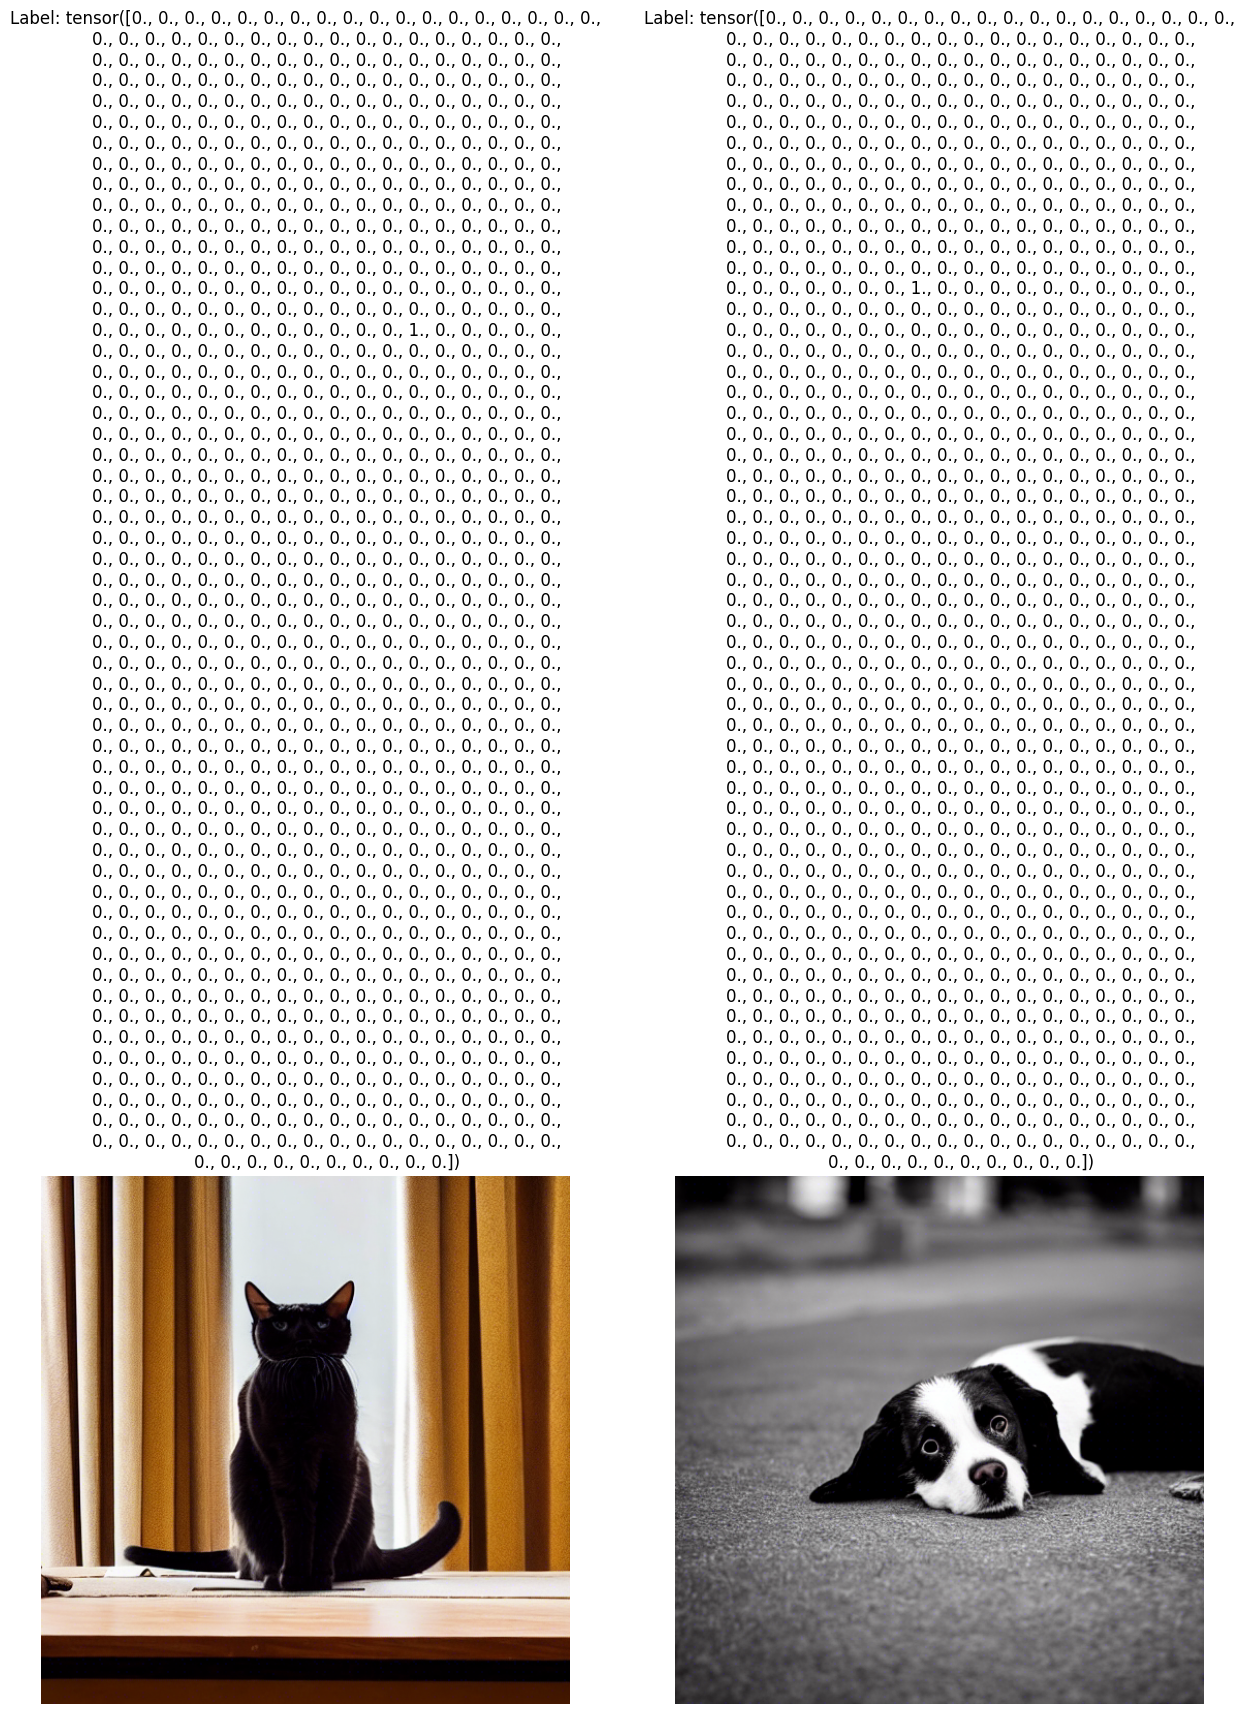

In [18]:
for i,(images, labels) in enumerate(dataloader):
    images = images
    labels = labels
    images_array = images.numpy()

    # 이미지와 라벨을 출력
    fig, axes = plt.subplots(1, len(images), figsize=(15,15))
    for ax, img, lbl in zip(axes, images_array, labels):
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')

    plt.show()
    break


# Accuracy reproduction

In [ ]:
labels

In [ ]:
preds = torch.tensor([[0,0.5,0.5,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,1,0]])

In [ ]:
from torchmetrics.classification.accuracy import Accuracy

In [ ]:
acc_top1 = Accuracy(task='multilabel', num_labels=10, top_k=1, average='micro')
acc_top2 = Accuracy(task='multilabel', num_labels=10, top_k=2, average='micro')

mc_acc_top1 = Accuracy(task='multiclass', num_classes=10, top_k=1, average='micro')

In [ ]:
def convert_multilabel_to_multiclass(preds, targets):
    # Take the argmax to convert to multi-class format
    mc_preds = torch.argmax(preds, dim=1)
    mc_targets = torch.argmax(targets, dim=1)
    return mc_preds, mc_targets

In [ ]:
conv_pred, conv_target = convert_multilabel_to_multiclass(preds, labels)

In [ ]:
print(conv_pred)
print(conv_target)

In [ ]:
mc_acc_top1(conv_pred, conv_target)

In [ ]:
acc_top2(preds, labels)

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res

In [ ]:
labels

In [ ]:
accuracy(preds.float(), labels, topk=(1,2))